In [1]:
import numpy as np
import Code
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import random

## <span style="color:orange">  **Cadre général de la descente de gradient stochastique pour obtenir une estimation du maximum de vraisemblance**  </span>

On se donne un échantillon d'observations $\boldsymbol{x} \in \mathbb{R}^{20} = [x^{(1)}, ..., x^{(20)}]^T$ tiré selon une loi paramétrée par $\theta$, qui est donc le paramètre du modèle probabiliste que nous souhaitons estimer. La log-vraisemblance des données observées $\ell (\theta) = \log p_{\theta}(\boldsymbol{x}) = \sum_{i=1}^{20} \log p_{\theta}(x^{(i)})$ est maximisée pour obtenir une estimation de maximum de vraisemblance (EMV) du paramètre $\theta$. 

En utilisant la **descente de gradient stochastique (SGD)**, l'algorithme pour estimer les paramètres peut être formulé comme suit :


1. **Initialisation** : On choisit un $\theta^{(0)}$ De manière aléatoire ou déterministe. On peut par exemple choisir une telle valeur à partir d'une première approximation.

2. **Itération** : À chaque itération $t$, les paramètres $\theta$ sont mis à jour en utilisant un échantillon aléatoire de données $x^{(i)}$ (donc pour $i \in \{1, ..., 20\}$) tiré de l'ensemble de données et on a alors : 
\begin{equation}
\theta^{(t+1)} = \theta^{(t)} - \eta \nabla_{\theta} \log p_{\theta^{(t)}}(x^{(i)}),
\end{equation}

    où $\eta$ est le **taux d'apprentissage** (également appelé pas d'apprentissage) et $\nabla_{\theta} \log p_{\theta^{(t)}}(\boldsymbol{x}^{(i)})$ est le gradient du logarithme de la vraisemblance conditionnelle évalué pour l'échantillon $\boldsymbol{x}^{(i)}$ à l'itération $t$. 

3. **Convergence** : On répète $(1)$ jusqu'à ce qu'un critère d'arrêt prédéfini soit satisfait. Par exemple, on peut fixer pour un $\epsilon$ donné le critère d'arrêt suivant :  
$$ 
\| \theta^{(t+1)} - \theta^{(t)} \| < \epsilon
$$



### <span style="color:violet">  1.1. **Calcul explicite du gradient de la log-vraisemblance**  </span>

Dans l'article, pour effectuer l'expérience empirique, on nous donne la valeur explicite de la densité avec laquelle on tire les observations $\boldsymbol{x}$. On nous donne : 

$$
p_{\theta}(\boldsymbol{x}) = \mathcal{N}(\boldsymbol{x}|\theta \mathbf{1}_{20}, 2\mathbf{I}_{20}) = \frac{1}{(4\pi)^{10}} \exp \left\{ -\frac{1}{4} (\boldsymbol{x} - \theta \mathbf{1}_{20})^T  (\boldsymbol{x} - \theta \mathbf{1}_{20}) \right\}
$$

Ainsi, on a : 

$$
\log p_{\theta}(\boldsymbol{x}) = \sum_{i=1}^{20}  \log p_{\theta}(x^{(i)}) = \sum_{i=1}^{20} \log \left( \frac{1}{2\sqrt{\pi}} \exp\left(-\frac{(x - \theta)^2}{4}\right) \right)
$$

Une fois cette expression explicite de la log-vraisemblance obtenue, on peut calculer explicitement le gradient de celle-ci **par rapport au paramètre  $\theta$**. On a : 

$$
\nabla_{\theta} \log p_{\theta} (\boldsymbol{x}) = \sum_{i=1}^{20}  \log \nabla_{\theta} p_{\theta}(x^{(i)}) = \frac{1}{2} \sum_{i=1}^{20} (x^{(i)} - \theta)
$$

Si bien que l'on retrouve la version du gradient **en un point** de l'échantillon $\boldsymbol{x}$ que l'on utilise dans l'étape itérative : 

$$
\nabla_{\theta} \log p_{\theta}(x^{(i)}) = \frac{1}{2} (x^{(i)} - \theta)
$$

A MODIFIER + ERREUR D

### <span style="color:violet">  1.2. **Tirage du paramètre génératif $\theta$**  </span>

Avant toute chose, on tire une valeur du paramètre $\theta$ que l'on considère comme étant la quantité que l'on souhaite approximer dans la suite de cette partie. On sait d'après le cadre de l'application numérique de l'article que $\theta \sim \mathcal{N}(1, 0)$. 

In [2]:
#theta_true = np.random.multivariate_normal(np.zeros(20), np.identity(20))
theta_true = np.random.normal(0, 1)
print(f"La valeur de theta à estimer est {theta_true}")

La valeur de theta à estimer est 0.2700757111025037


### <span style="color:violet">  1.3. **Tirage de l'échantillon**  </span>

In [3]:
def p_theta_x(theta_val):
    
    x = []

    for _ in range(20):
        x.append(np.random.normal(loc=theta_val, scale=np.sqrt(2)))

    return x

true_x = p_theta_x(theta_true)

print(f"L'échantillon d'observation x de taille 20 sur lequel on travaillera tiré est \n \n {true_x}")

L'échantillon d'observation x de taille 20 sur lequel on travaillera tiré est 
 
 [2.056948515976391, -1.5754790853180172, 1.795495705853603, 1.1677129245726634, -0.3055298090643941, -1.3950078300646558, -0.8983084196588546, 1.2877601790498994, -0.4817172279154345, -0.6344557437606904, 2.247319678417429, -0.10837324004200499, -0.2682017018124947, 3.1173166573324957, 2.7338693872933453, 1.9669471194570547, -1.3932013555059957, 0.8129227992569387, 0.2978899656114728, 0.34268362201861]


### <span style="color:violet">  1.4. **Adaptation de l'itération avec des estimation du gradient**  </span>

 l'idée est désormais d'adapter l'étape itérative décrite précédemment. Dans le cas où celle-ci est mise à jour à partir d'une estimation du gradient. On notera $\hat{\nabla}^{\text{SUMO}}_{\theta}, \hat{\nabla}^{\text{ML-SS}}_{\theta}, \hat{\nabla}^{\text{ML-RR}}_{\theta}$ et $\hat{\nabla}^{\text{IWAE}}_{\theta}$ l'estimateur du gradient selon les quatre méthodes sur lesquels repose nous travail (SUMO, ML_SS, ML_RR et IWAE).

**Itération** : Par exemple, en utilisant l'estimateur du gradient avec la méthode SUMO, on a l'itération $t$ du paramètres $\theta$ donnée, en utilisant un échantillon aléatoire de données $x^{(i)}$ (donc pour $i \in \{1, ..., 20\}$) tiré de l'ensemble de données : 
\begin{equation}
\theta^{(t+1)} = \theta^{(t)} - \eta \hat{\nabla}^{\text{SUMO}}_{\theta} (x^{(i)}),
\end{equation} 

A MODIFIER (?)

### <span style="color:violet">  1.4. **Étape itérative avec des estimation du gradient**  </span>

In [4]:
def SGD_iteration(theta_t, true_x, eta, r, k_IWAE, n_simulations, method):

    ## on tire un indice entre 0 et 19 (inclus)
    random_index = random.randint(0, 19)

    ## On crée un vecteur de taille 20 dont tous les éléments sont nuls, sauf celui donnée par l'index random_index
    modified_x = np.zeros(20)
    modified_x[random_index] = true_x[random_index]

    ## on recalcule noised_A et noised_b SELON LE PARAMÈTRE PRÉCÉDENT theta_t
    A, b = np.eye(20), (theta_t/2)*np.ones(20)
    noised_A, noised_b = Code.noised_params(A, b)

    if method == 'IWAE':
        ## on calcule le gradient selon l'estimateur donné dans method
        grad_theta_t = Code.grad_IWAE(modified_x, noised_A, noised_b, theta_t, k_IWAE, n_simulations)

    elif method == 'SUMO':
        ## on calcule le gradient selon l'estimateur donné dans method
        grad_theta_t = Code.grad_SUMO(r, modified_x, noised_A, noised_b, theta_t, n_simulations)

    elif method == 'ML_SS':
        ## on calcule le gradient selon l'estimateur donné dans method
        grad_theta_t = Code.grad_IWAE(r, modified_x, noised_A, noised_b, theta_t, n_simulations)

    elif method == 'ML_RR':
        ## on calcule le gradient selon l'estimateur donné dans method
        grad_theta_t = Code.grad_IWAE(r, modified_x, noised_A, noised_b, theta_t, n_simulations)

    theta_next =  theta_t - eta * grad_theta_t

    return theta_next

In [5]:
def SGD_iteration_tom(true_x, sum_log, position, theta_t, eta, r, k_IWAE, n_simulations, method):

    #modified_x = true_x[position]

    ## on recalcule noised_A et noised_b SELON LE PARAMÈTRE PRÉCÉDENT theta_t
    #A, b = np.eye(20), (theta_t/2)*np.ones(20)
    #noised_A, noised_b = Code.noised_params(A, b)
    
    A, b = np.eye(2), (theta_t/2)*np.ones(2)
    noised_A, noised_b = Code.noised_params(A, b, dim=2)

    if method == 'IWAE':
        ## on calcule le gradient selon l'estimateur donné dans method
        grad_theta_t = Code.grad_IWAE(true_x, noised_A, noised_b, float(theta_t), k_IWAE, n_simulations, dim = 2, one_shot=True)

    elif method == 'SUMO':
        ## on calcule le gradient selon l'estimateur donné dans method
        grad_theta_t = Code.grad_SUMO(r, true_x, noised_A, noised_b, float(theta_t), n_simulations, dim = 2, one_shot=True)

    elif method == 'ML_SS':
        ## on calcule le gradient selon l'estimateur donné dans method
        grad_theta_t = Code.grad_ML_SS(r, true_x, noised_A, noised_b, float(theta_t), n_simulations, dim = 2, one_shot=True)

    elif method == 'ML_RR':
        ## on calcule le gradient selon l'estimateur donné dans method
        grad_theta_t = Code.grad_ML_RR(r, true_x, noised_A, noised_b, float(theta_t), n_simulations, dim = 2, one_shot=True)

     ## On prend le ième terme de notre somme et cela sera celui-ci que l'on dérive à cette itération
    sum_log[position] = grad_theta_t

    theta_next =  theta_t + eta * sum(sum_log)/len(sum_log) ## ON est sur du gradient ascent

    return theta_next, sum_log

Une fois le code pour les itération fini, on s'attaque à la convergence de l'algorithme de descendre de gradient stochastique rien

In [33]:
def SGD_convergence(theta_0, true_x, eps, eta, r, k_IWAE, n_simulations, method):
    
    ## On initialise la somme des log pour chaque i
    sum_log = []

    if method == 'IWAE':
        
        #for i in range(10):
            #sum_log.append(Code.grad_IWAE(true_x[i, i+1], np.eye(20), (theta_0/2)*np.ones(20), theta_0, k_IWAE, n_simulations, dim = 2, one_shot=True, range=1))
        for i in range(len(true_x)) : 
            sum_log.append(Code.grad_IWAE([true_x[2*i], true_x[2*i+1]], np.eye(2), (theta_0/2)*np.ones(2), theta_0, k_IWAE, n_simulations, dim = 2, one_shot=True, range=1))

    elif method == 'SUMO':

        for i in range(len(true_x)) : 
            sum_log.append(Code.grad_SUMO(r, [true_x[2*i], true_x[2*i+1]], np.eye(2), (theta_0/2)*np.ones(2), theta_0, n_simulations, dim = 2, one_shot=True, range=1))

    elif method == 'ML_SS':

        for i in range(len(true_x)) : 
            sum_log.append(Code.grad_ML_SS(r, [true_x[2*i], true_x[2*i+1]], np.eye(2), (theta_0/2)*np.ones(2), theta_0, n_simulations, dim = 2, one_shot=True, range=1))
    
    elif method == 'ML_RR':

        for i in range(10):
            sum_log.append(Code.grad_ML_RR(r, [true_x[2*i], true_x[2*i+1]], np.eye(2), (theta_0/2)*np.ones(2), theta_0, n_simulations, dim = 2, one_shot=True, range=1))
        #for i in range(len(true_x)) : 
            #sum_log.append(Code.grad_ML_RR(r, true_x[i], np.eye(2), (theta_0/2)*np.ones(2), theta_0, n_simulations, dim = 2, one_shot=True, range=1))

    print(f" voici la sommelog {sum_log}")

    theta_t = [0, theta_0]
    #theta_t.append(SGD_iteration_tom(true_x[], sum_log, 0, theta_0, eta, r, k_IWAE, n_simulations, method)[0])
    t = 1
    #while abs(theta_t[t] - theta_t[t-1]) > eps:
    while abs(theta_t[t] - theta_true) > eps:
        
        ## peut-être que l'on peut inverser les deux boucles cela ferait plus de sens mais c'est pour voir si ça s'arrête

        for i in range(10):
            
            theta_next, sum_log = SGD_iteration_tom([true_x[2*i], true_x[2*i+1]], sum_log, i, theta_t[t], eta, r, k_IWAE, n_simulations, method)
            
            theta_t.append(theta_next)
            print(theta_next)
            if abs(theta_next - theta_true) < eps:
                return theta_t
            else : 
                t += 1
        #for i in range(len(true_x)):
            #print(f'thetaT{theta_t[t]}')
            #theta_next, sum_log = SGD_iteration_tom(true_x[i], sum_log, i, theta_t[t], eta, r, k_IWAE, n_simulations, method)
            #print(f"thetaNext{theta_next}")
            #if abs(theta_next - theta_t[t]) < eps:
                #return theta_next
            #else : 
                #theta_t.append(theta_next)
                #t += 1

    return theta_t

In [34]:
theta_0 = -3
#eta = 0.0001
#eps = 0.001
eta = 0.1
eps = 0.01
r = 0.6
k_IWAE = 5
n_simulations = 2
method = 'ML_RR'

SGD_conv = SGD_convergence(theta_0, true_x, eps, eta, r, k_IWAE, n_simulations, method)

 voici la sommelog [0.08248578586178645, -0.10928179593208842, 0.46671221768201754, 0.11310003583601347, 0.3187212979392613, 0.3218274947557678, -1.9126638378372984, -1.0391351175080148, 0.04489048378496863, 0.02928005242541687]
-3.0102967404485286
-3.007431286960884
-3.0038816620331805
-2.992497625037402
-2.976783378571782
-2.9930337713110706
-2.9708713435366945
-2.929079475663955
-2.882587774310202
-2.830888039572115
-2.7822059638766503
-2.7305191617771993
-2.6771120715842596
-2.627064767052311
-2.577634592168351
-2.5040629615545673
-2.577377125280572
-2.648998785106657
-2.717046649987116
-2.7837265772328097
-2.8492620622615816
-2.918339224014925
-2.999740643964068
-3.087191254325894
-3.1763199586846196
-3.2412663764318017
-3.18165331140051
-3.1437094791672986
-3.10586232473494
-3.06849201925782
-3.033540494104094
-2.9902956669702045
-2.935533424483309
-2.8728043500411378
-2.8094363889557172
-2.7598612156925624
-2.6960864230247163
-2.632950221138654
-2.5750010053829504
-2.51777661885

In [37]:
def plot_convergence(convergence_values, theta_true):
    """
    Trace la convergence des points vers la valeur du vrai paramètre.

    Args:
    - convergence_values (list or numpy array): Liste des valeurs de convergence de l'algorithme.
    - theta_true (float): Valeur vraie du paramètre.

    """
    num_iterations = len(convergence_values)  # Nombre d'itérations
    iterations = np.arange(1, num_iterations + 1)  # Numéro des itérations

    plt.figure(figsize=(10, 6))
    plt.scatter(iterations, convergence_values, color='blue', label='Convergence')
    plt.axhline(y=theta_true, color='red', linestyle='--', label='True Parameter Value')

    plt.title('Convergence vers la valeur du vrai paramètre')
    plt.xlabel('Iterations')
    plt.ylabel('Valeur de convergence')
    plt.legend()
    plt.grid(True)
    plt.show()


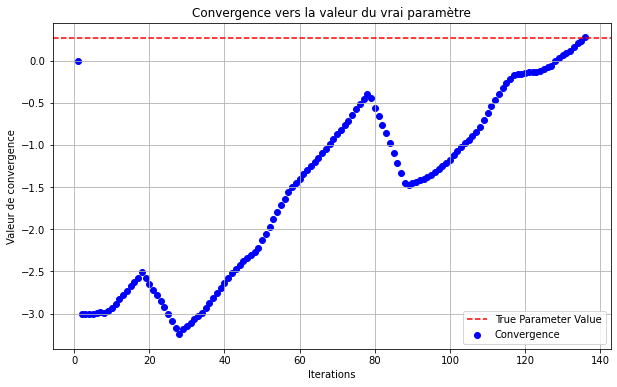

In [38]:
plot_convergence(SGD_conv, theta_true)

La descente de gradient stochastique (SGD) est un algorithme d'optimisation largement utilisé pour estimer les paramètres d'un modèle probabiliste par maximum de vraisemblance. L'algorithme fonctionne de la manière suivante :

1. Choisir un point initial $ \theta_0 $ dans l'espace des paramètres.
2. Itération jusqu'à convergence :
2.1. Échantillonnage stochastique : Sélectionner aléatoirement un échantillon $(x_i, y_i)$ parmi les données d'entraînement.
2.2. Calcul du gradient : Calculer le gradient de la fonction de perte par rapport aux paramètres du modèle en utilisant l'échantillon sélectionné : $ \nabla_{\theta} \mathcal{L}(\theta; x_i, y_i) $.
2.3. Mise à jour des paramètres : Mettre à jour les paramètres du modèle en utilisant le gradient calculé et un taux d'apprentissage $ \eta $ : $ \theta_{t+1} = \theta_t - \eta \nabla_{\theta} \mathcal{L}(\theta_t; x_i, y_i) $.


\textbf{Remarques :}
\begin{itemize}
    \item Le terme "stochastique" vient du fait que le gradient est calculé sur un seul échantillon à la fois, ce qui rend l'algorithme adapté aux grands ensembles de données.
    \item Le choix du taux d'apprentissage \( \eta \) est crucial ; un taux d'apprentissage trop grand peut entraîner des oscillations et une convergence instable, tandis qu'un taux d'apprentissage trop petit peut ralentir la convergence.
    \item La convergence de l'algorithme dépend de plusieurs facteurs, notamment du choix du taux d'apprentissage, de la fonction de perte utilisée et de la nature de l'ensemble de données.
\end{itemize}

